# Activations, Gradientts, BatchNorm
## Fix initialization
* network should start with equal probs for each character
* loss = -log(1/27.)  = 3.295
* for this logits need to be close to zero / non extreme values
* weights should be small but not zero
* hidden states(h) take values -1,1 for most/ most h pre activation take extreme values.
* when back propagating, 
* if 1,-1 grad = 1-h^2 * previous_grad, which kills the back prop after tanh
* this is true for any activation with squashes/ has a region where its flat;
* h pre activation should be closer to zero and not extreme as well

## Deviations / scale of weights
* the scale of x,y should both have std_dev close to 1
* but when we do y= x@w y is more spread
* to scale down so std_dev is 1
*  W = W / sqrt(INPUT_DIM) for tanh  / F.init.kaiming_normal_(tensor,activation)
* though modern optimizers care less for init

## Batch Normalization
* hidden states pre activation should be gaussian at initilization
* not extreme which saturates tanh, not too small which makes tanh useless
* the distribution should be able to move for different batches 
    1. scale/ normalize (x - u_x)/std_x
    2. shift  (x - u_x)/std_x + B
`h_pre = Bn_gain * (h_pre - h_pre.mean(0,keepdim=True)) / h_pre.std(0,keepdim=True) + Bn_bias`  at initilization

* this can cause bugs, so layer norm,group norm, etc are used


In [1]:
import math

math.exp(6.0)

NameError: name 'exp' is not defined

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [146]:
words = open('names.txt','r').read().split('\n')

chars = sorted(list(set(''.join(words))))
S_I = {c:i+1 for i,c in enumerate(chars)}
S_I['.'] = 0
I_S = {i:c for c,i in S_I.items()}

In [147]:
block_size = 3  # context size
vocab_size = len(S_I)
def build_dataset(words):
    # build the dataset
   

    X,Y = [],[] # input, labels
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = S_I[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.Tensor(X).int()
    Y = torch.Tensor(Y).int()
    print(X.shape,Y.shape)
    return X,Y

# split into train val and test
random.seed(42)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train,Y_train = build_dataset(words[:n1])  #train network
X_val,Y_val = build_dataset(words[n1:n2])    # tune hyperparameters
X_test,Y_test = build_dataset(words[n2:])    # final evaluation

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [148]:
# MLP
n_embed = 10 # embedding size / size of lookup table
n_hidden = 200 # hidden layer size
GAIN =5/3 # gain for tanh
e= 1e-8 # epsilon for batch norm to avoid divide by 0
INIT_SCALE = GAIN/((n_embed * block_size)+ e)**.5 # scale = gain / sqrt(fan_in)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embed),generator=g)  # lookup table
W1 = torch.randn(( n_embed * block_size ,n_hidden ),generator=g) * INIT_SCALE  # weights for the hidden layer
B1 = torch.randn((n_hidden,),generator=g) * 0
W2 = torch.randn((n_hidden,vocab_size),generator=g) * .01 # intialize the weights to small values
B2 = torch.randn((vocab_size),generator=g) * 0   # intialize the bias to 0

Bn_gain = torch.ones((1,n_hidden))
Bn_bias = torch.zeros((1,n_hidden))
Bn_mean_running = torch.zeros((1,n_hidden))
Bn_std_running = torch.ones((1,n_hidden))

params = [C,W1,B1,W2,B2,Bn_gain,Bn_bias]
for p in params:
    p.requires_grad_(True)

In [157]:
BATCH_SIZE = 64
MAX_STEPS = 90000
lossi=[]

for i in range(MAX_STEPS):
    # create minibatch
    ix = torch.randint(0,len(X_train),(BATCH_SIZE,)) # random indices
    Xb,Yb = X_train[ix],Y_train[ix]
    
    # forward pass
    emb = C[Xb] # embedding layer / input to tanh layer 
    embcat = emb.reshape((emb.shape[0],-1)) # flatten
    h_pre = embcat @ W1# + B1 # pre-activation 
    bnmi = h_pre.mean(0,keepdim=True)
    bnstdi = h_pre.std(0,keepdim=True)
    h_pre = Bn_gain * (h_pre - bnmi) / bnstdi + Bn_bias # batch normalization # bn_bias replaces B1
    
    with torch.no_grad():
        Bn_mean_running = .999 * Bn_mean_running + .001 * bnmi
        Bn_std_running = .999 * Bn_std_running + .001 * bnstdi
        
    h = torch.tanh(h_pre) # hidden layer
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits,Yb.long())
    
    #backward pass
    for p in params:
        p.grad = torch.zeros_like(p)
    loss.backward(retain_graph=True)
   
    # update the parameters
    lr = 0.1 if i<MAX_STEPS/5 else 0.01
    for p in params:
        p.data -= p.grad * lr
        
    #track
    if i%5000==0:
        print(i,loss.item())
    lossi.append(loss.log10().item())
    
print(loss.item())  # loss for a single batch

KeyboardInterrupt: 

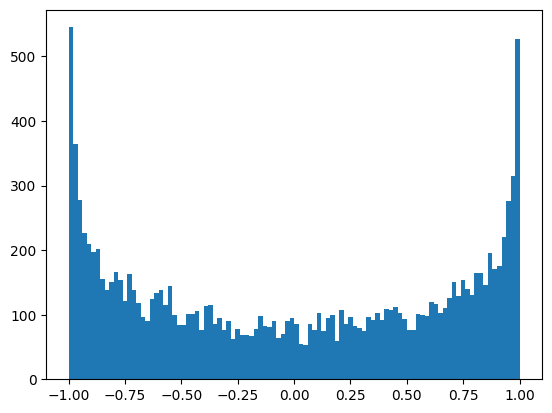

In [150]:
plt.hist(h.view(-1).tolist(),bins=100); # distribution of activations

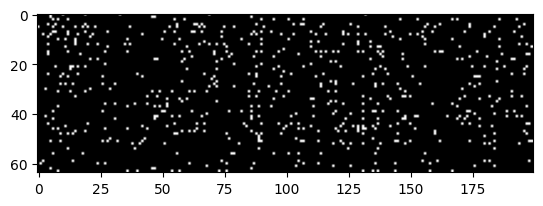

In [151]:
plt.figure()
plt.imshow(h.abs()>.99,cmap='gray') 
# if a whole column is white, then the corresponding neuron is dead

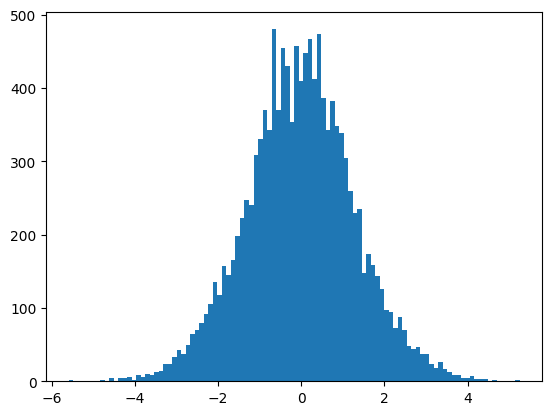

In [152]:
plt.hist(h_pre.view(-1).tolist(),bins=100); # pre-activation values

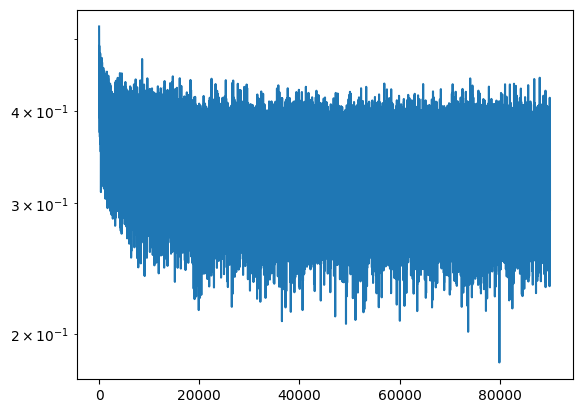

In [153]:
plt.plot(lossi)
plt.yscale('log')

In [154]:
# # calibrate batch normalization after training or calculate running mean and std
# with torch.no_grad():
#     emb = C[X_train]
#     embcat = emb.view((emb.shape[0],-1))
#     h_pre = embcat @ W1 + B1
#     Bn_mean = h_pre.mean(0,keepdim=True)
#     Bn_std = h_pre.std(0,keepdim=True)
    

In [155]:
@torch.no_grad() # don't track gradients for this function
def split_loss(split):
    x,y={
        'train':(X_train,Y_train),
        'val':(X_val,Y_val),
        'test':(X_test,Y_test)
    }[split]
    emb = C[x]
    embcat = emb.view((emb.shape[0],-1))
    h_pre = embcat @ W1 + B1
    h_pre = Bn_gain * (h_pre - Bn_mean_running) / Bn_std_running + Bn_bias # batch normalization
    h = torch.tanh(h_pre)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits,y.long())
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 2.108346939086914
val 2.134812593460083


In [156]:
# sampling
G = torch.Generator().manual_seed(2147483647+0)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=G).item()
        context = context[1:] + [ix]
        out.append(I_S[ix])
        if I_S[ix] == '.':
            break 
    print(''.join(out))

junnded.
luckyzharllah.
blby.
frith.
toldonsstev.
bdannikustbbrendasshbyshnrwisth.
shan.
caylandy.
ffredmaryffrtumj.
phnnslewhryannycord.
brengffryshandrynd.
mikshrynin.
fradsn.
svikhomszahddgorffrth.
gillis.
phnn.
shdy.
jksrull.
grumfyri.
mjed.
